In [49]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f"Versi TensorFlow: {tf.__version__}")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ SUKSES: GPU Terdeteksi ({gpus[0].name}) - Memory Growth Aktif")
    except RuntimeError as e:
        print(f"❌ Error Config GPU: {e}")
else:
    print("⚠️ PERINGATAN: GPU tidak terdeteksi. Training berjalan di CPU.")

Versi TensorFlow: 2.10.1
✅ SUKSES: GPU Terdeteksi (/physical_device:GPU:0) - Memory Growth Aktif


In [50]:
DATASET_DIR = 'Dataset_Anggur'  # Pastikan nama folder ini benar
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.0001
SPLIT_RATIO = 0.2

if not os.path.exists(DATASET_DIR):
    print(f"❌ ERROR KRUSIAL: Folder '{DATASET_DIR}' tidak ditemukan!")

In [51]:
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Wajib agar input range [-1, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=SPLIT_RATIO
)

print("\nMemuat Dataset...")
try:
    # Generator Latihan
    train_generator = data_gen.flow_from_directory(
        DATASET_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    # Generator Validasi/Testing
    test_generator = data_gen.flow_from_directory(
        DATASET_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False # Jangan diacak agar evaluasi rapi
    )

    # Deteksi Kelas
    NUM_CLASSES = train_generator.num_classes
    class_names = list(train_generator.class_indices.keys())
    print(f"Kelas Terdeteksi ({NUM_CLASSES}): {class_names}")

    # Hitung Penyeimbang Data (Class Weights)
    cls_train = train_generator.classes
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(cls_train),
        y=cls_train
    )
    weights_dict = dict(enumerate(class_weights))
    print(f"Bobot Penyeimbang Aktif: {weights_dict}")

except Exception as e:
    print(f"❌ Error Data: {e}")
    NUM_CLASSES = 0 # Safety flag


Memuat Dataset...
Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.
Kelas Terdeteksi (4): ['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']
Bobot Penyeimbang Aktif: {0: 0.8609639830508474, 1: 0.7341915085817525, 2: 0.9439605110336817, 3: 2.3974926253687316}


In [54]:
def build_custom_cnn():
    """Membangun CNN dari nol (From Scratch)"""
    model = Sequential(name='Custom_CNN')
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    # Blok 1-4
    for filters in [32, 64, 128, 256]:
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(2, 2))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

def build_mobilenet():
    """Membangun Transfer Learning MobileNetV2"""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True  # Full Fine-tuning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions, name='MobileNetV2')
    return model

In [56]:
def plot_battle_results(history_storage):
    """Menampilkan grafik perbandingan Akurasi & Loss"""
    plt.figure(figsize=(15, 6))
    
    # Plot Akurasi
    plt.subplot(1, 2, 1)
    for name, hist in history_storage.items():
        plt.plot(hist['val_accuracy'], linewidth=3, label=f'{name} (Test)')
        plt.plot(hist['accuracy'], linestyle='--', linewidth=1, alpha=0.7, label=f'{name} (Train)')
    plt.title('Battle: Perbandingan Akurasi')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(); plt.grid(True)
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    for name, hist in history_storage.items():
        plt.plot(hist['val_loss'], linewidth=3, label=f'{name} (Test)')
    plt.title('Battle: Perbandingan Loss (Makin Rendah Makin Baik)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(); plt.grid(True)
    
    plt.tight_layout(); plt.show()

def show_confusion_matrix(y_true, y_pred, model_name):
    """Menampilkan Confusion Matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Label Asli')
    plt.xlabel('Label Prediksi')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    print(f"\nLaporan Klasifikasi {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [57]:
models_list = [
    ('Custom CNN', build_custom_cnn),
    ('MobileNetV2', build_mobilenet)
]

# Penyimpanan hasil untuk visualisasi akhir
battle_results = {}

if NUM_CLASSES > 0:
    for name, builder in models_list:
        print(f"\n{'='*40}")
        print(f"🚀 MULAI TRAINING: {name}")
        print(f"{'='*40}")

        # 1. Reset Memory
        tf.keras.backend.clear_session()
        
        # 2. Build & Compile
        model = builder()
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        try:
            # 3. Training Process
            history = model.fit(
                train_generator,
                steps_per_epoch=train_generator.samples // BATCH_SIZE,
                validation_data=test_generator,
                validation_steps=test_generator.samples // BATCH_SIZE,
                epochs=EPOCHS,
                class_weight=weights_dict,
                verbose=1 # Tampilkan progress bar
            )
            
            # 4. Prediksi untuk Evaluasi
            print(f"\nMenghitung Statistik Akhir {name}...")
            test_generator.reset()
            probs = model.predict(test_generator, verbose=0)
            y_pred = np.argmax(probs, axis=1)
            y_true = test_generator.classes
            
            # Simpan data penting ke dictionary
            battle_results[name] = {
                'history': history.history,
                'y_true': y_true,
                'y_pred': y_pred
            }
            
        except Exception as e:
            print(f"❌ Error saat training {name}: {e}")


🚀 MULAI TRAINING: Custom CNN
Epoch 1/10
203/203 [==============================] - 45s 215ms/step - loss: 0.7885 - accuracy: 0.7697 - val_loss: 2.5697 - val_accuracy: 0.0938
Epoch 2/10
203/203 [==============================] - 40s 196ms/step - loss: 0.5747 - accuracy: 0.8563 - val_loss: 1.5651 - val_accuracy: 0.4625
Epoch 3/10
203/203 [==============================] - 40s 197ms/step - loss: 0.5105 - accuracy: 0.8807 - val_loss: 0.6503 - val_accuracy: 0.8288
Epoch 4/10
203/203 [==============================] - 41s 200ms/step - loss: 0.4662 - accuracy: 0.8924 - val_loss: 0.4861 - val_accuracy: 0.8888
Epoch 5/10
203/203 [==============================] - 40s 197ms/step - loss: 0.4445 - accuracy: 0.9113 - val_loss: 0.4001 - val_accuracy: 0.9438
Epoch 6/10
203/203 [==============================] - 40s 198ms/step - loss: 0.3964 - accuracy: 0.9286 - val_loss: 0.3720 - val_accuracy: 0.9425
Epoch 7/10
203/203 [==============================] - 41s 202ms/step - loss: 0.3674 - accuracy: 0.93


📊 HASIL AKHIR


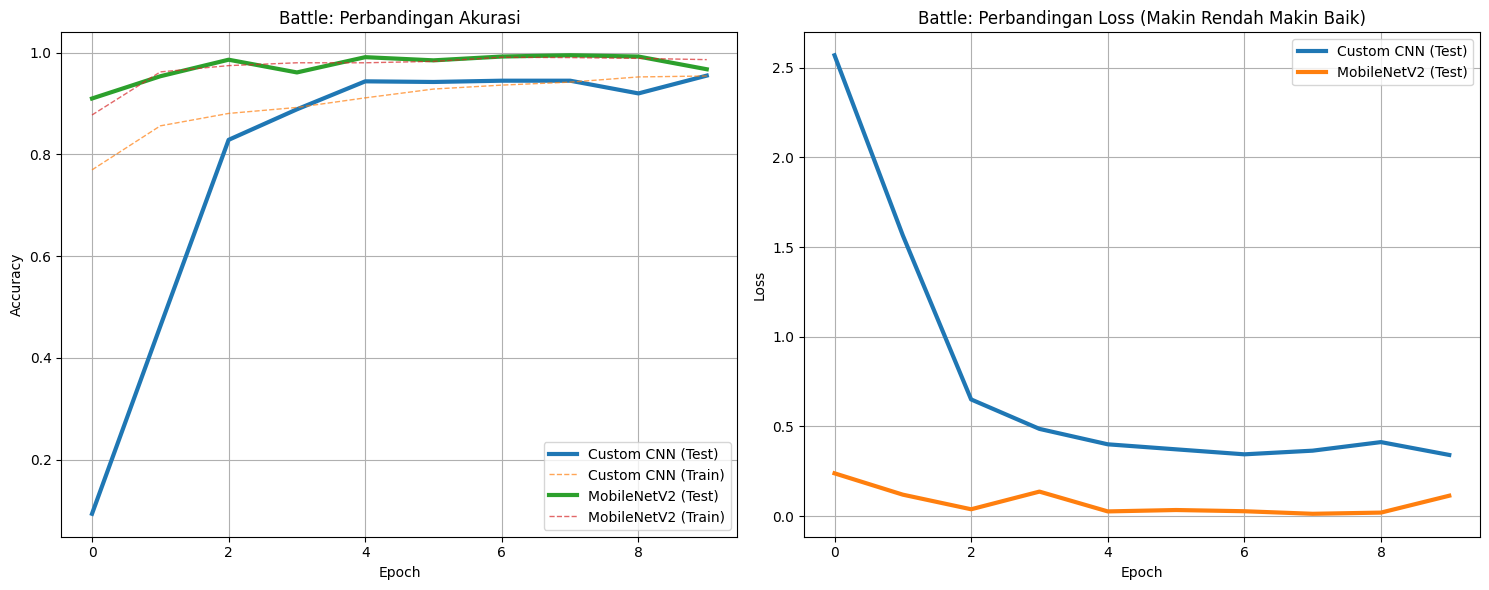


>>> Analisis Detail: Custom CNN <<<


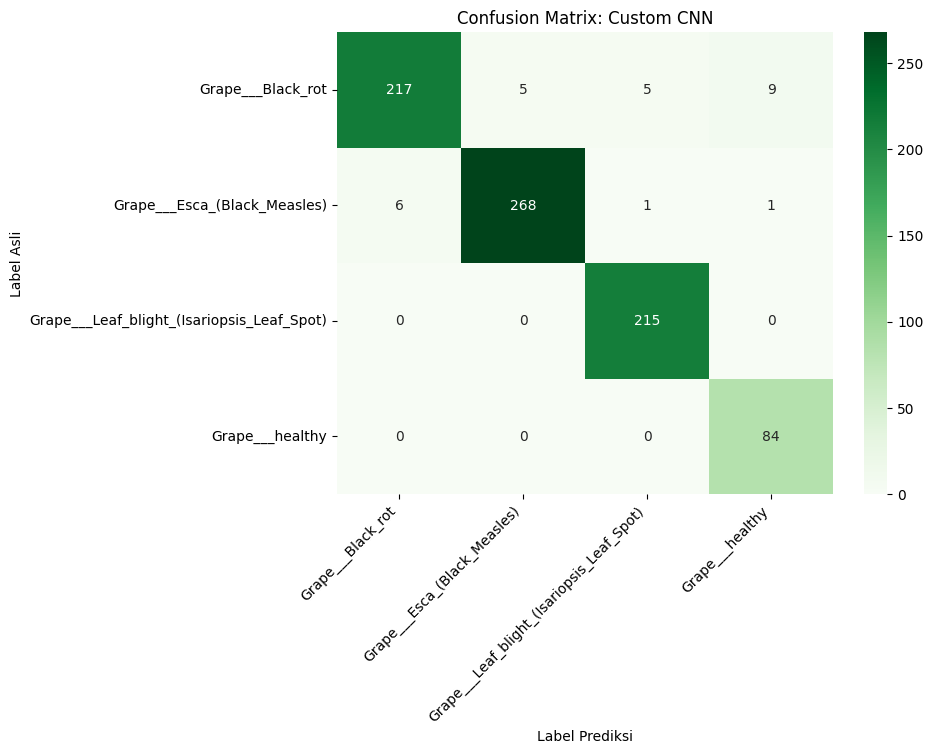


Laporan Klasifikasi Custom CNN:
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.97      0.92      0.95       236
              Grape___Esca_(Black_Measles)       0.98      0.97      0.98       276
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.97      1.00      0.99       215
                           Grape___healthy       0.89      1.00      0.94        84

                                  accuracy                           0.97       811
                                 macro avg       0.96      0.97      0.96       811
                              weighted avg       0.97      0.97      0.97       811


>>> Analisis Detail: MobileNetV2 <<<


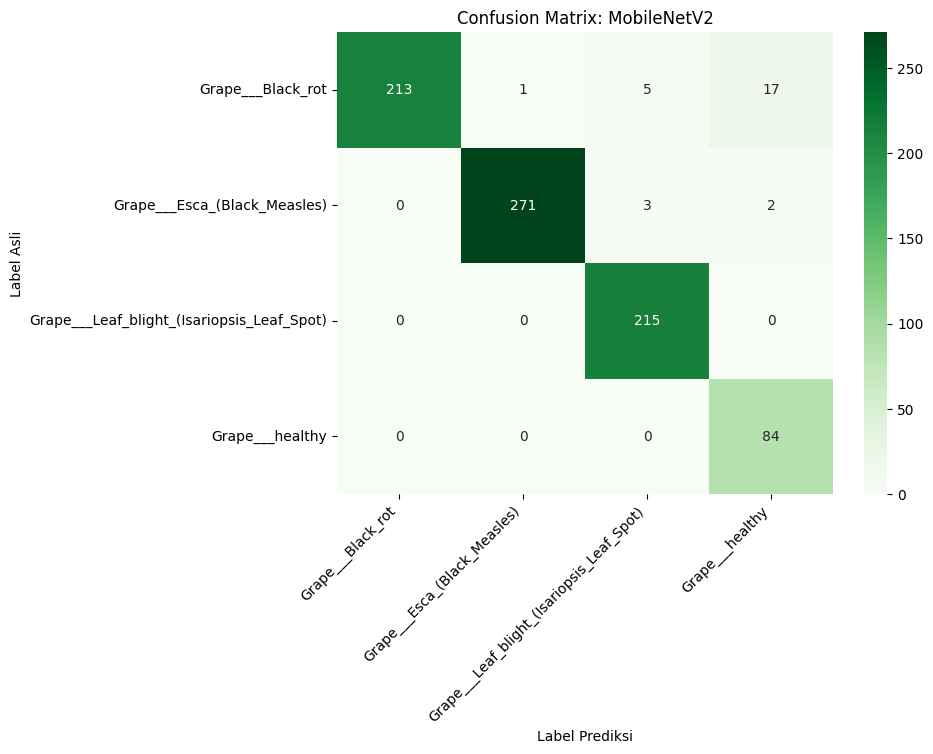


Laporan Klasifikasi MobileNetV2:
                                            precision    recall  f1-score   support

                         Grape___Black_rot       1.00      0.90      0.95       236
              Grape___Esca_(Black_Measles)       1.00      0.98      0.99       276
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.96      1.00      0.98       215
                           Grape___healthy       0.82      1.00      0.90        84

                                  accuracy                           0.97       811
                                 macro avg       0.94      0.97      0.95       811
                              weighted avg       0.97      0.97      0.97       811

Custom CNN  : 95.50%
MobileNetV2 : 99.50%


In [60]:
if battle_results:
    print("\n" + "="*40)
    print("📊 HASIL AKHIR")
    print("="*40)
    
    # A. Tampilkan Grafik Perbandingan
    # Mengambil dictionary history dari hasil simpanan
    histories = {name: res['history'] for name, res in battle_results.items()}
    plot_battle_results(histories)
    
    # B. Tampilkan Confusion Matrix per Model
    for name, res in battle_results.items():
        print(f"\n>>> Analisis Detail: {name} <<<")
        show_confusion_matrix(res['y_true'], res['y_pred'], name)
        
    # C. Penentuan Juara
    acc_custom = max(battle_results['Custom CNN']['history']['val_accuracy'])
    acc_mobile = max(battle_results['MobileNetV2']['history']['val_accuracy'])
    
    print(f"Custom CNN  : {acc_custom*100:.2f}%")
    print(f"MobileNetV2 : {acc_mobile*100:.2f}%")

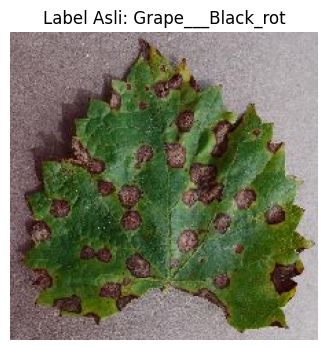

File: Grape___Black_rot\06ca4e74-f852-4ee1-8100-2c88eccdf450___FAM_B.Rot 0585.JPG
Custom CNN   -> Prediksi: Grape___Leaf_blight_(Isariopsis_Leaf_Spot) (88.65%)
MobileNetV2  -> Prediksi: Grape___Black_rot (100.00%)


In [63]:
import random

# 1. Ambil 1 gambar acak dari Test Set
idx = random.randint(0, len(test_generator.filenames) - 1)
file_path = test_generator.filenames[idx]
true_label = class_names[test_generator.classes[idx]]
full_path = os.path.join(test_generator.directory, file_path)

# 2. Tampilkan Gambar
img = load_img(full_path, target_size=(IMG_SIZE, IMG_SIZE))
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Label Asli: {true_label}")
plt.axis('off')
plt.show()

# 3. Prediksi dengan Model Battle
print(f"File: {file_path}")
x = preprocess_input(np.expand_dims(img_to_array(img), axis=0))
builders = dict(models_list)

if weights_storage:
    for name, weights in weights_storage.items():
        # Rebuild model & load weights
        model = builders[name]()
        model.set_weights(weights)
        
        # Prediksi
        pred = model.predict(x, verbose=0)[0]
        label = class_names[np.argmax(pred)]
        conf = np.max(pred)
        
        print(f"{name:12} -> Prediksi: {label} ({conf:.2%})")
else:
    print("❌ Tidak ada bobot model yang tersimpan. Lakukan training terlebih dahulu.")